In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce # for merging dataframes
import sqlite3
import re
import os

In [157]:
def load_data():
    conn = sqlite3.connect('data/Database.db') 
          
    sql_query1 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM coilDataInput
                               ''', conn)
    sql_query2 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B3_table
                               ''', conn)
    sql_query3 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B4_table
                               ''', conn)
    sql_query4 = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM B5_table
                               ''', conn)


    main_df = pd.DataFrame(sql_query1, columns = ['coil', 'furnace Number', 'analyse', 'Hardness_1', 'Hardness_2',
       'Width', 'Temperature before finishing mill',
       'Temperature after finishing mill', 'Thickness', 'Thickness profile',
       'C', 'Mn', 'Si', 'Nb', 'P', 'S', 'Al', 'M_Al', 'B', 'N', 'Ti', 'Cr',
       'V', 'Mo'])


    B3_df =pd.DataFrame(sql_query2, columns = ['coilId', 'lengthCoordinate', 'B3'])
    B4_df =pd.DataFrame(sql_query3, columns = ['coilId', 'lengthCoordinate', 'B4'])
    B5_df =pd.DataFrame(sql_query4, columns = ['coilId', 'lengthCoordinate', 'B5'])

    B3_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B3':'width_B3'}, inplace = True)
    B4_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B4':'width_B4'}, inplace = True)
    B5_df.rename(columns = {'coilId':'coil', 'lengthCoordinate':'length', 'B5':'width_B5'}, inplace = True)
    
    B3_df.to_csv('data/csv_data/B3.csv', index = False, header = True) # save df into csv file
    B4_df.to_csv('data/csv_data/B4.csv', index = False, header = True)
    B5_df.to_csv('data/csv_data/B5.csv', index = False, header = True)
    main_df.to_csv('data/csv_data/coilData.csv', index = False, header = True )

    
    
    


In [158]:
def visualize_measurments(measurement_df, name, constriction, count):
    """
     This functions makes plot for each coil Id

    """

    constriction_dir ='images/constriction/'
    not_constriction_dir = 'images/not_constriction/'
    #print(measurement_df.head(20))
    
    x_upper_limit = measurement_df['length'].max() - 10
    measurement_df=measurement_df[(measurement_df.length >=100) &(measurement_df.length <= x_upper_limit -10)]
    y_lower_limit, y_higher_limit = measurement_df[['width_B3', 'width_B4','width_B5']].min().min().min(), measurement_df[['width_B3', 'width_B4','width_B5']].max().max().max()
    
    fig, ax = plt.subplots()
    ax.plot(measurement_df['length'], measurement_df['width_B3'], color = 'b', label = 'B3', linewidth = 1)
    ax.plot(measurement_df['length'], measurement_df['width_B4'], color = 'r', label = 'B4', linewidth = 1)
    ax.plot(measurement_df['length'], measurement_df['width_B5'], color = 'g', label = 'B5', linewidth = 1)

    
    ax.set(xlabel='length in meters', ylabel='width in millimeters',title= name)

    ax.set_ylim(y_lower_limit -1, y_higher_limit + 1) # limit plot dynamically according the data
    ax.set_xlim(100,x_upper_limit)
    
    ax.set_xticks([120,190], minor=True)
    ax.xaxis.grid(True, which='minor')
    
    if count < 200: # only save the first 200
        if constriction == 0: # saves images with constriction and not constriction in seperate folde
             fig.savefig(not_constriction_dir + str(name) +'.png', dpi = 72)
        else:
             fig.savefig(constriction_dir + str(name) + '.png', dpi = 72) 

    
    if count <= 5: # show plot only for the first 5 coils
        plt.show()
    else:
        plt.close()

    

In [159]:
def set_constriction():
    """ 
    This function determine whether a coil is constricted or not based on B3,B4,B5 measurement
    It adds a new column "Is_constriction" to the main data frame
    
    """
    load_data()
    B3_df = pd.read_csv('data/csv_data/B3.csv')
    B4_df = pd.read_csv('data/csv_data/B4.csv')
    B5_df = pd.read_csv('data/csv_data/B5.csv')
    main_df = pd.read_csv('data/csv_data/CoilData.csv')

    coil_label_list = []   # keeps coil Id , Is_constriction(0|1),constriction_width
    
    missing_file_error = [] # keeps coil Id , with either B3,B4,B5 file is missing
    missing_data_error = [] # keeps coil Id,  with either B3.B4,B5 has missing data
    unclassified_error = [] # keeps coil Id , with unknown error

    count = 0  # track the number of coils
    
    for index, row in main_df['coil'].items():
        try:
            print('row :',row)
            if((row not in B3_df.values)|(row not in B4_df.values)|(row not in B5_df.values)):
                missing_file_error.append(row)
                continue

            B3_row_df = B3_df[B3_df['coil']== row][['length','width_B3']]
            B4_row_df = B4_df[B4_df['coil']== row][['length','width_B4']]
            B5_row_df = B5_df[B5_df['coil']== row][['length','width_B5']]

            if((B3_row_df.empty)|(B4_row_df.empty)|(B5_row_df.empty)):
                missing_data_error.append(row)
                continue

            B3_index = B3_row_df[(B3_row_df['length'] <= 50)|(B3_row_df['length'] >= 300)|(B3_row_df['width_B3'] == 0)].index
            B4_index = B4_row_df[(B4_row_df['length'] <= 50)|(B4_row_df['length'] >= 300)|(B4_row_df['width_B4'] == 0)].index
            B5_index = B5_row_df[(B5_row_df['length'] <= 50)|(B5_row_df['length'] >= 300)|(B5_row_df['width_B5'] == 0)].index

            B3_row_df.drop(B3_index, inplace = True)
            B4_row_df.drop(B4_index, inplace = True)
            B5_row_df.drop(B5_index, inplace = True)

            B3_row_df['length'] = B3_row_df['length'].astype(int) # convert float value to int
            B4_row_df['length'] = B4_row_df['length'].astype(int)
            B5_row_df['length'] = B5_row_df['length'].astype(int)

            B3_grouped_row_df = B3_row_df.groupby('length', as_index=False)['width_B3'].mean(numeric_only =True)
            B4_grouped_row_df = B4_row_df.groupby('length', as_index=False)['width_B4'].mean(numeric_only =True)
            B5_grouped_row_df = B5_row_df.groupby('length', as_index=False)['width_B5'].mean(numeric_only =True)

            dfs = [B3_grouped_row_df, B4_grouped_row_df, B5_grouped_row_df]
            measurement_df = reduce(lambda  left,right: pd.merge(left,right,on=['length'],
                                            how='outer'), dfs)# merge all DataFrames into one
    
            targeted_measurement_df = measurement_df[(measurement_df.length >=120) &(measurement_df.length <= 190)].copy()
            targeted_measurement_df.loc[:, 'B3B4_mean_width'] = targeted_measurement_df.loc[:, ['width_B3','width_B4']].mean(1)
            targeted_measurement_df.loc[:, 'width_difference'] = targeted_measurement_df.loc[:, 'width_B5'] - targeted_measurement_df.loc[:, 'B3B4_mean_width']

            def constriction_status(value):
                if abs(value) <= 5:
                    return 0
                else:
                    return 1
            
            targeted_measurement_df.loc[:, 'Is_constriction'] = targeted_measurement_df.loc[:, 'width_difference'].map(constriction_status)
            constriction_width = len(targeted_measurement_df[targeted_measurement_df['Is_constriction']==1])

            if constriction_width >= 1:
                constriction = 1
            else:
                constriction = 0
            
            coil_label_list.append({'coil':row, 'Constriction_width':constriction_width, 'Is_constriction':constriction})
            count += 1 # increament number of coils processed
            visualize_measurments(measurement_df,row, constriction, count) # visualize


        except:
            unclassified_error.append(row)
        if count == 10:
            break
            
    label_df = pd.DataFrame(coil_label_list)
    main_labeled_df = pd.merge(main_df,label_df, on ='coil')
    
    print(f'{len(missing_file_error)} coils have either B3,B4 B5 file missing : ', missing_file_error)
    print(f'{len(missing_data_error)} coils have either B3,B4 B5 file  empty: ', missing_data_error)
    print(f'{len(unclassified_error)} coils have unclassified error : ', unclassified_error)


    return main_labeled_df,coil_label_list
    
    
       

row : 283642
row : 283643
row : 283644
row : 283645
row : 283646
row : 283647
row : 283649
row : 283650
row : 283651
row : 283652
row : 283653
row : 283654
row : 283655
row : 283656
row : 283657
row : 283658
row : 283659
row : 283660
row : 283661
row : 283662
row : 283663
row : 283664
row : 283665
row : 283666
row : 283667
row : 283668
row : 283669
row : 283670
row : 283671
row : 283675
row : 283676
row : 283677
row : 283678
row : 283679
row : 283680
row : 283681
row : 283682
row : 283683
row : 283684
row : 283687
row : 283688
row : 283689
row : 283690
row : 283691
row : 283692
row : 283693
row : 283694
row : 283695
row : 283696
row : 283697
row : 283700
row : 283701
row : 283702
row : 283703
row : 283704
row : 283705
row : 283706
row : 283707
row : 283708
row : 283709
row : 283710
row : 283711
row : 283712
row : 283713
row : 283714
row : 283715
row : 283716
row : 283717
row : 283718
row : 283719
row : 283720
row : 283721
row : 283722
row : 283723
row : 283724
row : 283725
row : 283726

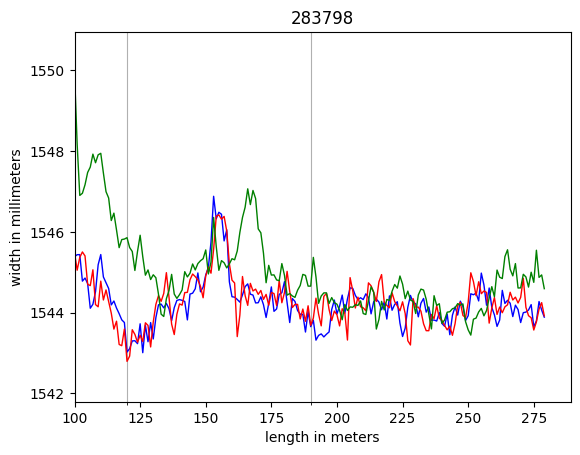

row : 283800
    length     width_B3     width_B4     width_B5
0       50  1534.602250  1534.601750  1540.213333
1       51  1534.248000  1534.350500  1540.106333
2       52  1533.376667  1533.948667  1539.217250
3       53  1533.420000  1533.736500  1538.395000
4       54  1532.798000  1532.661000  1537.392333
5       55  1531.876000  1532.166333  1537.041250
6       56  1531.560500  1531.750000  1536.255667
7       57  1531.549000  1531.588250  1537.021250
8       58  1530.887667  1530.925333  1537.044667
9       59  1531.128750  1531.052250  1536.503333
10      60  1530.962750  1531.011500  1536.840750
11      61  1530.670333  1530.577333  1536.704000
12      62  1530.604250  1529.727750  1535.286667
13      63  1530.407000  1530.086250  1535.687500
14      64  1529.833667  1529.771333  1535.794667
15      65  1529.407000  1530.060250  1535.460667
16      66  1528.904750  1529.567750  1534.334000
17      67  1528.461000  1528.786333  1534.097000
18      68  1528.164250  1528.398500 

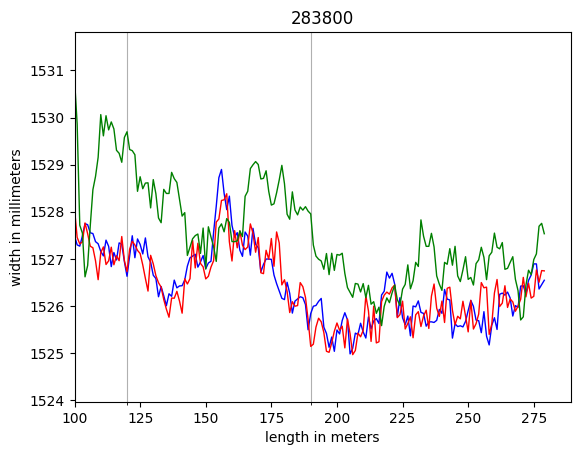

row : 283801
    length     width_B3     width_B4     width_B5
0       50  1540.688667  1541.710333  1542.830000
1       51  1540.931000  1541.417500  1542.718000
2       52  1541.842500  1541.181500  1543.141000
3       53  1541.771000  1540.851667  1543.371333
4       54  1541.656250  1540.944250  1542.723000
5       55  1541.449667  1540.891667  1542.896667
6       56  1541.798250  1541.035250  1542.826667
7       57  1541.515000  1541.926750  1543.249750
8       58  1542.283000  1541.502333  1542.235000
9       59  1542.232000  1542.107750  1542.184667
10      60  1542.662667  1542.459667  1542.088750
11      61  1543.119750  1542.758250  1541.920667
12      62  1543.230000  1542.555667  1541.005000
13      63  1543.172000  1543.148250  1540.960250
14      64  1543.267333  1543.301333  1541.151667
15      65  1543.616750  1543.223000  1541.406750
16      66  1543.550667  1543.521000  1541.850333
17      67  1543.500250  1543.361750  1542.445667
18      68  1543.447333  1543.446333 

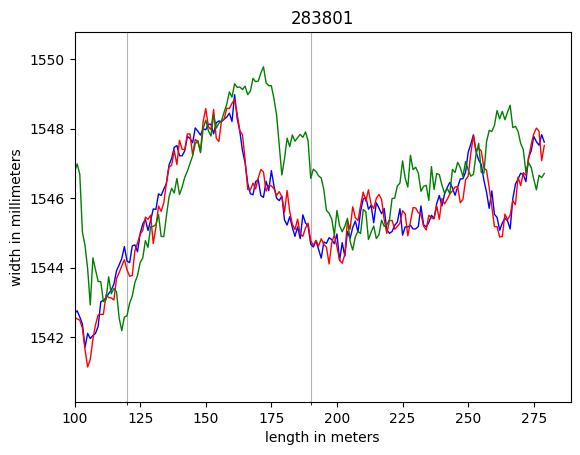

row : 283802
    length     width_B3     width_B4     width_B5
0       50  1552.045750  1552.045000  1552.856667
1       51  1551.852000  1552.114000  1553.166500
2       52  1550.922667  1551.806000  1553.070667
3       53  1551.143500  1551.349250  1553.522500
4       54  1550.647500  1551.140500  1553.592000
5       55  1549.924667  1550.665333  1554.006333
6       56  1549.734250  1549.969250  1553.798250
7       57  1549.345750  1549.134500  1554.511333
8       58  1549.319000  1548.934667  1555.107250
9       59  1548.929250  1548.584500  1554.915667
10      60  1548.800000  1548.346250  1554.891500
11      61  1548.706000  1548.399000  1554.595000
12      62  1548.787000  1548.351750  1554.100000
13      63  1548.335667  1548.499667  1553.813500
14      64  1547.573500  1547.527000  1552.960333
15      65  1547.079500  1547.358500  1552.860750
16      66  1546.682000  1547.318333  1552.542333
17      67  1546.770000  1546.795000  1552.037667
18      68  1546.822000  1546.888000 

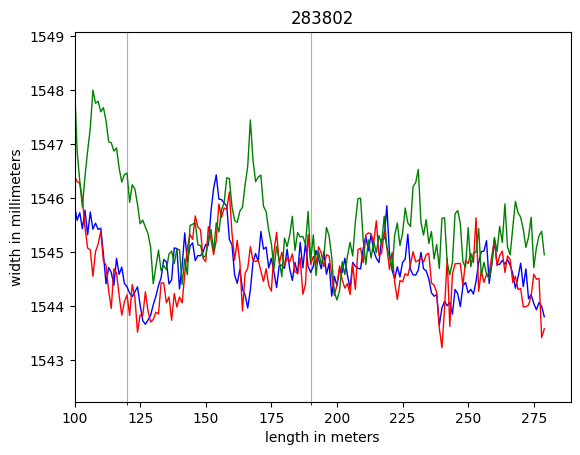

row : 283803
    length     width_B3     width_B4     width_B5
0       50  1560.700333  1560.416333  1564.178000
1       51  1561.290667  1560.888667  1563.201667
2       52  1561.923000  1560.699250  1562.961000
3       53  1560.673333  1560.338000  1563.215000
4       54  1560.342667  1560.078333  1563.556000
5       55  1560.284000  1560.297333  1563.355667
6       56  1559.947250  1560.295000  1563.014333
7       57  1560.336000  1560.209667  1563.402333
8       58  1559.650333  1559.288333  1562.934333
9       59  1559.787000  1559.148250  1562.025000
10      60  1559.633000  1558.970000  1562.433000
11      61  1557.932000  1558.843333  1561.890667
12      62  1558.198667  1558.210667  1562.252333
13      63  1558.129500  1558.351750  1562.111667
14      64  1557.147333  1557.727333  1561.637000
15      65  1556.878667  1557.251667  1561.577000
16      66  1556.300333  1556.233000  1561.944667
17      67  1556.399500  1555.893500  1561.817667
18      68  1556.021000  1556.345333 

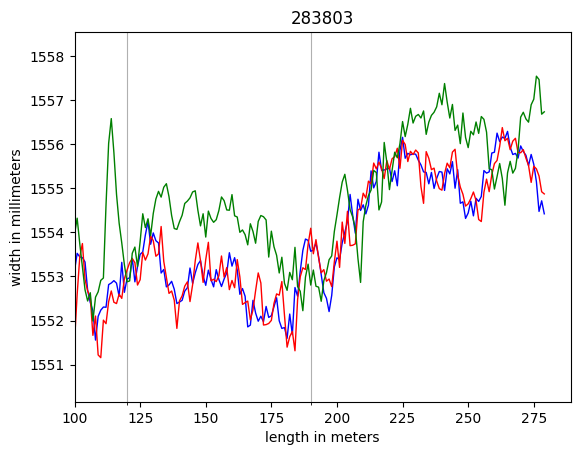

row : 283804
    length     width_B3     width_B4     width_B5
0       50  1540.732667  1541.363333  1546.876667
1       51  1540.308000  1540.699750  1546.413500
2       52  1539.421000  1539.412500  1546.081000
3       53  1538.995000  1539.667667  1546.268667
4       54  1538.533250  1539.057000  1544.919750
5       55  1537.814250  1538.152500  1545.299333
6       56  1537.439750  1537.180500  1545.011667
7       57  1537.251000  1537.107000  1544.132750
8       58  1536.608750  1537.133250  1543.213667
9       59  1535.992750  1536.477250  1543.500667
10      60  1535.728000  1535.614333  1542.367500
11      61  1535.179500  1535.752750  1542.498000
12      62  1534.787000  1534.684333  1541.943333
13      63  1534.867000  1534.265000  1542.184333
14      64  1534.416750  1534.012750  1540.929000
15      65  1534.128333  1534.153000  1540.880667
16      66  1533.927000  1534.067500  1540.372667
17      67  1533.841500  1532.890500  1539.214250
18      68  1533.015000  1532.339000 

In [160]:
df, label = set_constriction()

In [145]:
df.head()

,coil,furnace Number,analyse,Hardness_1,Hardness_2,Width,Temperature before finishing mill,Temperature after finishing mill,Thickness,Thickness profile,...,Al,M_Al,B,N,Ti,Cr,V,Mo,Constriction_width,Is_constriction
0,283801,NaN,KN41,11395,119,1546.216667,NaN,NaN,4.23050,NaN,...,381,363,1,41,14,153,0,2,0,0
1,283802,NaN,KN41,11446,119,1544.633333,NaN,NaN,4.38275,NaN,...,329,317,1,34,11,166,0,3,0,0
2,283803,NaN,KN31,11304,118,1554.183333,NaN,NaN,3.58925,NaN,...,345,329,1,28,23,258,0,22,0,0
3,283804,NaN,KN21,10785,113,1528.283333,NaN,NaN,4.36900,NaN,...,401,392,1,57,16,243,0,31,0,0
4,283805,NaN,KN21,10836,113,1512.616667,NaN,NaN,5.02125,NaN,...,376,356,1,45,11,296,0,26,5,1
